In [15]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
class Value:

    def __init__(self, data, isWeight, isBias, isActivation, isPreActivation, _children=(), _op='', label=''):
        # activation
        self.data = data
        # gradient
        self.grad = 0.0
        self.isWeight = isWeight
        self.isBias = isBias
        self.isActivation = isActivation
        self.isPreActivation = isPreActivation

        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, False, False, False, False)
        out = Value(self.data + other.data, False, False, False, False, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
                
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, False, False, False, False)
        out = Value(self.data * other.data, False, False, False, False, (self, other), '*')

        def _backward():
            # we do += to accumulate the gradient
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, False, False, False, False, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), False, False, False, False, (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        self.isPreActivation = True
        out = Value(t, False, False, True, False, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topological_sorted_v = []
        visited = set()
        dependents = {}
    
        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                dependents.setdefault(v, set())
                for child in v._prev:
                    dependents.setdefault(child, set())
                    dependents[child].add(v)
                    build_topological_sort(child)
                topological_sorted_v.append(v)
    
        build_topological_sort(self)
        self.grad = 1.0
    
        for v in reversed(topological_sorted_v):
            v._backward()
            if v.isWeight:
                print(f"{v.label}, data={v.data}, grad={v.grad}")
            if v.isBias:
                print(f"{v.label}, data={v.data}, grad={v.grad}")
            if v.isActivation:
                contributions = []
                total_grad = 0.0
                # Get layer number from v.label to ensure correct context
                layer_num = int(v.label.split(',')[0].split('_')[1])  # e.g., 'layer_1' -> 1
                neuron_num = v.label.split('activation')[1][1:-1]  # e.g., 'activation{1}' -> '1'
                for dep in dependents.get(v, set()):
                    if dep._op == '*':
                        weight = [n for n in dep._prev if n != v][0]
                        weight_label = weight.label if hasattr(weight, 'label') else 'unknown_weight'
                        # Next layer’s pre-activation (weight’s layer)
                        next_layer_num = int(weight_label.split(',')[0].split('_')[1])
                        next_neuron_num = weight_label.split('neuron_')[1].split(',')[0]
                        pre_act_label = f"layer_{next_layer_num}, pre-activation{next_neuron_num}"
                        contrib = weight.data * dep.grad
                        contributions.append((f"{weight_label} data * {pre_act_label} gradient", contrib))
                        total_grad += contrib
                if contributions:
                    print(f"{v.label}, data={v.data}, grad={v.grad}, contributions={contributions}, total_grad={total_grad}")
                else:
                    print(f"{v.label}, data={v.data}, grad={v.grad}")
            if v.isPreActivation:
                print(f"{v.label}, data={v.data}, grad (error_term)={v.grad}")

    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # self / other
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data})"
    

In [111]:
class Neuron:

    def __init__(self, num_weights, layer_num, neuron_num):
        # Initialize weights as Value objects with random small values
        # isWeight, isBias, isActivation
        self.weights = [Value(random.uniform(-1, 1), True, False, False, False, label=f"layer_{layer_num}, neuron_{neuron_num}, weight{_}") for _ in range(num_weights)]
        
        # Initialize bias as a Value object
        self.bias = Value(random.uniform(-1, 1), False, True, False, False, label=f"layer_{layer_num}, bias{neuron_num}")
        self.layer_num = layer_num
        self.neuron_num = neuron_num


    def forward(self, prev_activations):
        # Compute weighted sum
        weighted_sum = self.bias
        for prev_activation, weight in zip(prev_activations, self.weights):
            weighted_sum = weighted_sum.__add__(weight.__mul__(prev_activation))
            
        weighted_sum.label = f"layer_{self.layer_num}, pre-activation{self.neuron_num}"

        
        # Apply activation function (tanh)
        self.activation = weighted_sum.tanh()
        self.activation.isPreActivation = False
        self.activation.isActivation = True
        self.activation.isWeight = False
        self.activation.isBias = False
        self.activation.label = f"layer_{self.layer_num}, activation{self.neuron_num}"
        return self.activation

    def parameters(self):
        return self.weights + [self.bias]


class Layer:
    def __init__(self, num_prev_neurons, num_neurons, layer_num):
        self.neurons = [Neuron(num_prev_neurons, layer_num, {_}) for _ in range(num_neurons)]
        self.layer_num = layer_num

    def forward(self, prev_activations):
        self.activations = [neuron.forward(prev_activations) for neuron in self.neurons]
        return self.activations

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
    # inputs: number of inputs
    # layers: array of neuron counts: [2, 2, 1]
    def __init__(self, inputs, layers):
        self.layers = []
        total_layers = [inputs] + layers
        for i in range(len(layers)):
            self.layers.append(Layer(total_layers[i], total_layers[i+1], i))
            
        # for layer by layer backprop, keep track of the last layer backproped
        self.next_layer_to_backward = len(self.layers)-1

    def forward(self, activations):
        # Pass activations through each layer
        for layer in self.layers:
            activations = layer.forward(activations)
        return activations


    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    

In [112]:
# Example usage
net = MLP(1, [2, 2, 1])
x = [Value(0.5, False, False, False, False)]
y = [Value(0.75, False, False, False, False)]

output = net.forward(x)
print(f"Output: {output}")

# Assuming a simple loss like MSE
loss = (output[0] - y[0])**2
print(f"Loss: {loss.data}")

# Print gradients before any backprop
print("weight gradients before any backprop")
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


# Perform backward pass
print("weight gradients after backprop")
loss.backward()

Output: [Value(data=0.16410993109825356)]
Loss: 0.3432671728376932
weight gradients before any backprop
Layer 0 gradients:
  Neuron 0 weight gradients: [0.0]
  Neuron 1 weight gradients: [0.0]
Layer 1 gradients:
  Neuron 0 weight gradients: [0.0, 0.0]
  Neuron 1 weight gradients: [0.0, 0.0]
Layer 2 gradients:
  Neuron 0 weight gradients: [0.0, 0.0]
weight gradients after backprop
layer_2, activation{0}, data=0.16410993109825356, grad=-1.1717801378034929
layer_2, pre-activation{0}, data=0.16560747922348895, error_term=-1.14022167371094
layer_1, activation{1}, data=-0.8747424785967095, grad=0.0991569466928782, contributions=[('layer_2, neuron_{0}, weight1 data * layer_2, pre-activation{0} gradient', 0.0991569466928782)], total_grad=0.0991569466928782
layer_1, pre-activation{1}, data=-1.352927397468691, error_term=0.02328458911842712
layer_1, neuron_{1}, weight1, data=-0.08417144296524603, grad=0.01390648150562954
layer_1, bias{1}, data=-0.7631570268031194, grad=0.02328458911842712
layer_

In [74]:
# Numerical verification

def numerical_gradient(value_obj, x, net, y, h=1e-5):
    original_data = value_obj.data
    output = net.forward(x)
    loss_plus = (output[0] - y[0])**2
    value_obj.data = original_data + h
    output = net.forward(x)
    loss_plus_h = (output[0] - y[0])**2
    value_obj.data = original_data
    return (loss_plus_h.data - loss_plus.data) / h

w = net.layers[0].neurons[0].weights[0]
num_grad = numerical_gradient(w, x, net, y)
print(f"Analytical: {w.grad}, Numerical: {num_grad}")

Analytical: 0.08566434153712686, Numerical: 0.08566483815086733


In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right || TB = top to bottom || BT = bottom to top

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

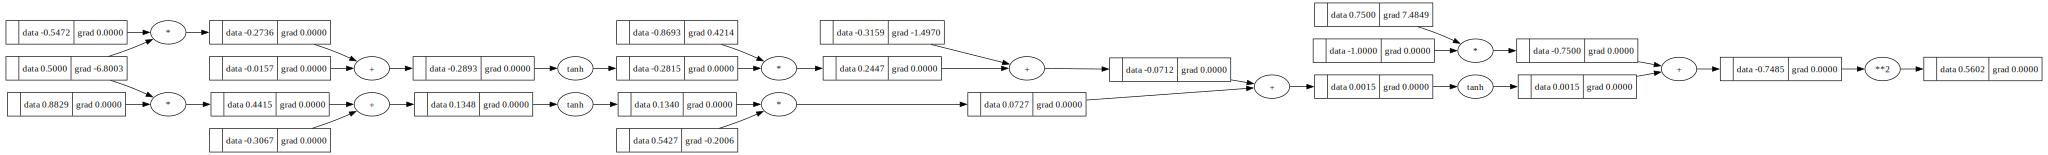

In [16]:
draw_dot(loss)

In [159]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp.forward(x) 
print(len(mlp.parameters()))
print('---')
    
# Create the training set: inputs: xs[i], outputs: ys[i]
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Assuming mlp.forward(x) returns a list or array with a single element
for k in range(100):
    # Forward pass
    ypred = [mlp.forward(sample) for sample in xs]

    # For next token prediction, use cross entropy loss instead of the mean squared error loss as used here
    loss = 1 / len(ys) * sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Initialize all the parameters's gradients to zero so they don't accumulate over each run of gradient descent
    for p in mlp.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Stochastic gradient descent update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

print(loss)
print(ypred)


41
---
0 1.2153578629155062
1 0.9844567825838071
2 0.869205213288464
3 0.808764028595076
4 0.7617993517386195
5 0.7181257219171191
6 0.6725268217019904
7 0.6202090997470132
8 0.5560585246431388
9 0.47709749813546903
10 0.38896137647823226
11 0.3056318676078152
12 0.23744367821097537
13 0.18604389326728932
14 0.14837504404212584
15 0.12074102448842305
16 0.10019388256743444
17 0.084636927351904
18 0.07262979199830225
19 0.06318805629909671
20 0.05563359495838839
21 0.04949275715421798
22 0.044429255583948946
23 0.040200227489108585
24 0.03662731549240276
25 0.033577420437255874
26 0.030949711192436155
27 0.02866672387234808
28 0.026668168901669627
29 0.024906556882228613
30 0.023344064105464378
31 0.02195025528683373
32 0.0207004074527272
33 0.019574261113755334
34 0.018555079057030254
35 0.01762892930642846
36 0.016784133320464856
37 0.016010837312479976
38 0.015300676251200185
39 0.014646508299368432
40 0.014042203272673838
41 0.013482472882984636
42 0.012962733562846033
43 0.01247899

In [ ]:
import random

class Neuron:
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(0.0)
    
    def forward(self, x):
        self.last_inputs = x  # Store inputs for backprop
        return sum(wi * xi for wi, xi in zip(self.weights, x)) + self.bias

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def forward(self, x):
        return [n.forward(x) for n in self.neurons]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def zero_grad(self):
        for layer in self.layers:
            for neuron in layer.neurons:
                for w in neuron.weights:
                    w.grad = 0
                neuron.bias.grad = 0
    
    def backward_stepwise(self, y, x):
        self.zero_grad()
        output = self.forward(x)
        loss = (output[0] - y[0]) ** 2
        
        # Store computation graph manually
        steps = []
        current = loss
        while current._prev:  # Traverse the computation graph
            # Zero gradients up to this point
            self.zero_grad()
            # Backprop to this node
            current.grad = 1.0  # Start with dL/dL = 1
            current._backward()  # Compute gradients for this step
            # Collect gradients
            grad_state = []
            for i, layer in enumerate(self.layers):
                layer_grads = []
                for j, neuron in enumerate(layer.neurons):
                    weight_grads = [w.grad for w in neuron.weights]
                    layer_grads.append(weight_grads)
                grad_state.append(layer_grads)
            steps.append(grad_state)
            # Move to the previous node(s) in the graph
            current = list(current._prev)[0] if len(current._prev) == 1 else current
        
        return steps[::-1]  # Reverse to show accumulation from input to output

# Test setup
net = MLP(1, [2, 2, 1])
x = [Value(0.5)]
y = [Value(0.75)]
gradient_steps = net.backward_stepwise(y, x)

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import numpy as np

def plot_gradient_accumulation(step):
    plt.clf()
    if step >= len(gradient_steps):
        step = len(gradient_steps) - 1
    grad_state = gradient_steps[step]
    
    # Flatten gradients for all layers
    all_grads = []
    labels = []
    for i, layer_grads in enumerate(grad_state):
        for j, neuron_grads in enumerate(layer_grads):
            all_grads.extend(neuron_grads)
            labels.extend([f"L{i}N{j}W{k}" for k in range(len(neuron_grads))])
    
    # Plot
    plt.bar(range(len(all_grads)), all_grads, tick_label=labels)
    plt.xticks(rotation=45)
    plt.title(f"Gradient Accumulation at Step {step}")
    plt.xlabel("Weight")
    plt.ylabel("Gradient Value")
    plt.tight_layout()
    plt.show()

# Create slider
interact(plot_gradient_accumulation, step=IntSlider(min=0, max=len(gradient_steps)-1, step=1, value=0))